### Read in and clean data

In [2]:
import pandas as pd
import re
from pathlib import Path

INPUT_PATH = "sap_press.csv"
OUTPUT_PATH = "sap_press_clean.csv"
TEXT_COL = "headline"
LABEL_COL = "label"
MIN_SAMPLES_PER_CLASS = 2

def normalize_label(x):
    if pd.isna(x): return x
    s = str(x).strip()
    if len(s) >= 2 and ((s[0] == s[-1] == '"') or (s[0] == s[-1] == "'")):
        s = s[1:-1].strip()
    return re.sub(r"\s+", " ", s).strip(" '\"\t\n\r")

def read_csv_robust(p):
    for enc in ["utf-8", "utf-8-sig", "latin-1"]:
        try:
            return pd.read_csv(p, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(p)

# 1) read
df = read_csv_robust(INPUT_PATH)
df.columns = [c.strip().lower() for c in df.columns]
assert TEXT_COL in df.columns and LABEL_COL in df.columns, df.columns

# 2) select & basic clean
keep_cols = [TEXT_COL, LABEL_COL] if "id" not in df.columns else ["id", TEXT_COL, LABEL_COL]
df = df[keep_cols].copy()
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()
df = df[df[TEXT_COL].str.len() > 0]
df[LABEL_COL] = df[LABEL_COL].apply(normalize_label)
df = df[df[LABEL_COL].notna() & (df[LABEL_COL].astype(str).str.len() > 0)]

# 3) deduplicate pairs
df = df.drop_duplicates(subset=[TEXT_COL, LABEL_COL])

# 4) remove rare classes
vc = df[LABEL_COL].value_counts()
rare_labels = vc[vc < MIN_SAMPLES_PER_CLASS].index.tolist()
removed_before = len(df)
if rare_labels:
    df = df[~df[LABEL_COL].isin(rare_labels)].copy()
removed_rare = removed_before - len(df)

# 5) save + report
df.to_csv(OUTPUT_PATH, index=False)

print("Saved:", OUTPUT_PATH)
print(f"Final rows: {len(df)}")
print(f"Classes kept: {df[LABEL_COL].nunique()}")
if rare_labels:
    print("Removed rare labels (count < {MIN_SAMPLES_PER_CLASS}):")
    for lbl in rare_labels:
        print(f"  - {lbl} (count={int(vc[lbl])})")
print("\nLabel distribution:")
print(df[LABEL_COL].value_counts())


Saved: sap_press_clean.csv
Final rows: 1410
Classes kept: 7
Removed rare labels (count < {MIN_SAMPLES_PER_CLASS}):
  - Bill Payment and More (count=1)

Label distribution:
label
Partnership      468
Award            328
Story            270
Financials       157
Solution          81
Merger/Invest     65
People            41
Name: count, dtype: int64


### EDA

Loaded cleaned dataset: sap_press_clean.csv
=== Label Distribution ===
           label  count  percent
0    Partnership    468    33.19
1          Award    328    23.26
2          Story    270    19.15
3     Financials    157    11.13
4       Solution     81     5.74
5  Merger/Invest     65     4.61
6         People     41     2.91


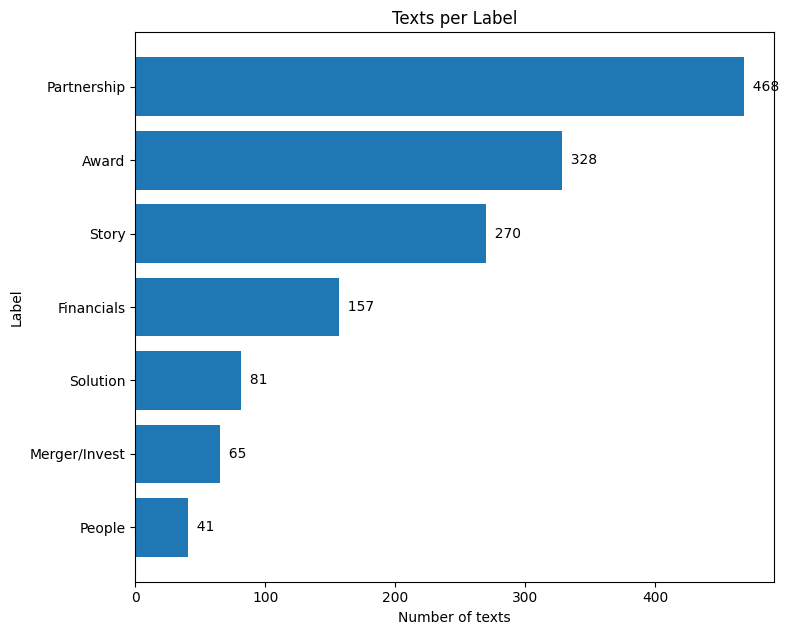

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CLEAN_PATH = "sap_press_clean.csv"
TEXT_COL = "headline"
LABEL_COL = "label"


def load_dataset():
    p = Path(CLEAN_PATH)
    df = pd.read_csv(CLEAN_PATH)
    print(f"Loaded cleaned dataset: {CLEAN_PATH}")
    return df

df = load_dataset()

cols = [c.lower() for c in df.columns]

df.columns = [c.lower() for c in df.columns]
TEXT_COL = TEXT_COL.lower()
LABEL_COL = LABEL_COL.lower()

counts = df[LABEL_COL].value_counts(dropna=False)
percent = (counts / counts.sum() * 100).round(2)
dist = pd.DataFrame({"count": counts, "percent": percent}).reset_index(names=LABEL_COL)

dist = dist.sort_values("count", ascending=False).reset_index(drop=True)

print("=== Label Distribution ===")
print(dist)

plt.figure(figsize=(8, 4 + 0.35 * len(dist)))
plt.barh(dist[LABEL_COL], dist["count"])
plt.xlabel("Number of texts")
plt.ylabel("Label")
plt.title("Texts per Label")
plt.gca().invert_yaxis()

for i, (lbl, cnt) in enumerate(zip(dist[LABEL_COL], dist["count"])):
    plt.text(cnt, i, f"  {cnt}", va="center")

plt.tight_layout()
plt.show()

### Base model

In [13]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"; os.environ["TRANSFORMERS_NO_FLAX"] = "1"

import numpy as np
import pandas as pd
from pathlib import Path
from transformers import pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

CLEAN_PATH = "sap_press_clean.csv"
TEXT_COL, LABEL_COL = "headline", "label"
MODEL_ZS = "roberta-large-mnli"
BATCH = 16
OUT_DIR = Path("zero_shot_eval")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Load data & canonical label maps (ordered) ---
df = pd.read_csv(CLEAN_PATH)
df.columns = [c.strip().lower() for c in df.columns]
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"text", LABEL_COL:"label"})

labels = sorted(df["label"].dropna().unique().tolist())
num_labels = len(labels)
label2id = {lbl: i for i, lbl in enumerate(labels)}
id2label = {i: lbl for i, lbl in enumerate(labels)}
index2name = [id2label[i] for i in range(num_labels)]

# --- Zero-shot classifier ---
clf = pipeline("zero-shot-classification", model=MODEL_ZS, device_map="auto")

def predict_zero_shot_batch(texts, candidate_labels=labels, multi_label=False):
    out = clf(texts, candidate_labels=candidate_labels, multi_label=multi_label)
    if isinstance(out, dict):
        out = [out]
    return [o["labels"][0] for o in out]

# --- Run predictions in batches ---
pred_labels = []
texts = df["text"].tolist()
for i in range(0, len(texts), BATCH):
    chunk = texts[i:i+BATCH]
    pred_labels.extend(predict_zero_shot_batch(chunk))

# --- Encode y_true / y_pred to ids (stable ordering) ---
y_true = np.array([label2id[lbl] for lbl in df["label"].tolist()])
y_pred = np.array([label2id[pl] for pl in pred_labels])

# --- Metrics  ---
print("\n=== Test Metrics ===")
print({
    "accuracy": accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
})

print("\n=== Classification Report ===")
print(classification_report(
    y_true, y_pred,
    labels=list(range(num_labels)),
    target_names=index2name,
    zero_division=0
))

# --- Confusion matrix  ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
cm_df = pd.DataFrame(cm, index=index2name, columns=index2name)
cm_path = OUT_DIR / "confusion_matrix_zero_shot.csv"
cm_df.to_csv(cm_path, index=True)
print(f"\nSaved confusion matrix to: {cm_path}")


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



=== Test Metrics ===
{'accuracy': 0.4695035460992908, 'macro_f1': np.float64(0.4175687933662365), 'weighted_f1': np.float64(0.4884229281689336)}

=== Classification Report ===
               precision    recall  f1-score   support

        Award       0.72      0.66      0.69       328
   Financials       0.67      0.70      0.69       157
Merger/Invest       0.66      0.42      0.51        65
  Partnership       0.72      0.47      0.57       468
       People       0.17      0.10      0.12        41
     Solution       0.13      0.77      0.23        81
        Story       0.21      0.09      0.12       270

     accuracy                           0.47      1410
    macro avg       0.47      0.46      0.42      1410
 weighted avg       0.56      0.47      0.49      1410


Saved confusion matrix to: zero_shot_eval\confusion_matrix_zero_shot.csv
Saved per-example predictions to: zero_shot_eval\zero_shot_predictions.csv


### Fine tuning

#1

In [ ]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

import numpy as np
import pandas as pd
from pathlib import Path
import random, torch
from inspect import signature

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
)
import evaluate

# ------------------ Config ------------------
CLEAN_PATH = "sap_press_clean.csv"
TEXT_COL, LABEL_COL = "headline", "label"
MODEL_NAME = "roberta-large-mnli"
MAX_LEN = 128
EPOCHS = 3
LR = 1.5e-5
BATCH_TRAIN = 8
BATCH_EVAL = 16
SEED = 4213
OUTPUT_DIR = "roberta_large_mnli_topic_detection"

GRADIENT_CHECKPOINTING = True
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

# ------------------ Repro -------------------
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

# ------------------ Data --------------------
df = pd.read_csv(CLEAN_PATH)
df.columns = [c.strip().lower() for c in df.columns]
assert TEXT_COL in df.columns and LABEL_COL in df.columns, df.columns
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL: "text", LABEL_COL: "label"})

labels = sorted(df["label"].unique().tolist())
label2id = {lbl: i for i, lbl in enumerate(labels)}
id2label = {i: lbl for i, lbl in enumerate(labels)}
num_labels = len(labels)
df["label_id"] = df["label"].map(label2id)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label_id"])
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df["label_id"])

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df[["text", "label_id"]].reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df[["text", "label_id"]].reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df[["text", "label_id"]].reset_index(drop=True)),
})

ds = ds.rename_column("label_id", "labels")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
def tok_fn(ex): return tokenizer(ex["text"], truncation=True, max_length=MAX_LEN)
tok = ds.map(tok_fn, batched=True, remove_columns=["text"])

# model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)
if GRADIENT_CHECKPOINTING:
    model.gradient_checkpointing_enable()

collator = DataCollatorWithPadding(tokenizer=tokenizer)
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=y_pred, references=y_true)["accuracy"],
        "macro_f1": f1_metric.compute(predictions=y_pred, references=y_true, average="macro")["f1"],
        "weighted_f1": f1_metric.compute(predictions=y_pred, references=y_true, average="weighted")["f1"],
    }

# TrainingArguments
ta_kwargs = dict(
    output_dir=OUTPUT_DIR,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    logging_steps=50,
    seed=SEED,
    report_to=[],
    fp16=torch.cuda.is_available(),
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
)
sig = signature(TrainingArguments.__init__)
if "evaluation_strategy" in sig.parameters:
    ta_kwargs["evaluation_strategy"] = "epoch"
else:
    ta_kwargs["eval_strategy"] = "epoch"

args = TrainingArguments(**ta_kwargs)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok["train"],
    eval_dataset=tok["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# ------------------ Train -------------------
trainer.train()
print("Best checkpoint:", trainer.state.best_model_checkpoint)
print("Validation:", trainer.evaluate())

# ------------------ Test --------------------
pred = trainer.predict(tok["test"])
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

print("\n=== Test Metrics ===")
print({
    "accuracy": accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
})

index2name = [id2label[i] for i in range(num_labels)]

print("\n=== Classification Report ===")
print(classification_report(
    y_true, y_pred,
    labels=list(range(num_labels)),
    target_names=index2name,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
cm_df = pd.DataFrame(cm, index=index2name, columns=index2name)
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
cm_path = Path(OUTPUT_DIR) / "confusion_matrix_full.csv"
cm_df.to_csv(cm_path, index=True)
print(f"\nSaved confusion matrix to: {cm_path}")

# ------------------ Save model ----------------
final_dir = Path(OUTPUT_DIR) / "final_full"
final_dir.mkdir(parents=True, exist_ok=True)
trainer.save_model(final_dir.as_posix())
tokenizer.save_pretrained(final_dir.as_posix())

# ------------------ Quick inference helper ----
def predict_topics(texts):
    enc = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LEN)
    enc = {k: v.to(model.device) for k, v in enc.items()}
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(**enc).logits, dim=-1).cpu().numpy()
    pred_ids = probs.argmax(axis=-1)
    return [{"text": t, "pred": id2label[i], "conf": float(probs[j, i])} for j,(t,i) in enumerate(zip(texts, pred_ids))]

print("\nExamples:")
for r in predict_topics([
    "Company announces strategic partnership to expand cloud footprint",
    "CFO reports record quarterly revenue growth",
]):
    print(r)


Map:   0%|          | 0/1128 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large-mnli and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.108700,0.886694,0.687943,0.487716,0.598011
2,0.525200,0.507026,0.822695,0.704948,0.797543
3,0.327100,0.586818,0.822695,0.727460,0.793282


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Best checkpoint: roberta_large_mnli_topic_detection\checkpoint-423


Validation: {'eval_loss': 0.5868181586265564, 'eval_accuracy': 0.8226950354609929, 'eval_macro_f1': 0.7274596405726469, 'eval_weighted_f1': 0.7932815658284061, 'eval_runtime': 7.9356, 'eval_samples_per_second': 17.768, 'eval_steps_per_second': 1.134, 'epoch': 3.0}

=== Test Metrics ===
{'accuracy': 0.8085106382978723, 'macro_f1': np.float64(0.7106595206890095), 'weighted_f1': np.float64(0.7833575239582462)}

=== Classification Report ===
               precision    recall  f1-score   support

        Award       0.97      0.91      0.94        33
   Financials       1.00      1.00      1.00        15
Merger/Invest       0.71      0.71      0.71         7
  Partnership       0.73      0.96      0.83        47
       People       1.00      0.75      0.86         4
     Solution       0.00      0.00      0.00         8
        Story       0.70      0.59      0.64        27

     accuracy                           0.81       141
    macro avg       0.73      0.70      0.71       141
 weigh

#2

In [ ]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"; os.environ["TRANSFORMERS_NO_FLAX"] = "1"

import random, numpy as np, pandas as pd, torch
from pathlib import Path
from inspect import signature
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback)
import evaluate
from peft import LoraConfig, get_peft_model, TaskType

# -------- Config --------
CLEAN_PATH = "sap_press_clean.csv"
TEXT_COL, LABEL_COL = "headline", "label"
MODEL_NAME = "roberta-large-mnli"
MAX_LEN = 128
EPOCHS = 5
LR = 2e-4
BATCH_TRAIN = 8
BATCH_EVAL  = 16
SEED = 4213
OUTPUT_DIR = "roberta_large_mnli_lora"

# LoRA params
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.1
TARGET_MODULES = ["query", "value"]

def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed()

# -------- Data --------
df = pd.read_csv(CLEAN_PATH)
df.columns = [c.strip().lower() for c in df.columns]
assert TEXT_COL in df.columns and LABEL_COL in df.columns, df.columns
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"text", LABEL_COL:"label"})

labels = sorted(df["label"].unique().tolist())
label2id = {lbl:i for i,lbl in enumerate(labels)}
id2label = {i:lbl for i,lbl in enumerate(labels)}
num_labels = len(labels)
df["label_id"] = df["label"].map(label2id)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label_id"])
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df["label_id"])

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df[["text","label_id"]].reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df[["text","label_id"]].reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df[["text","label_id"]].reset_index(drop=True)),
}).rename_column("label_id","labels")

# -------- Tokenizer --------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
def tok_fn(ex): return tokenizer(ex["text"], truncation=True, max_length=MAX_LEN)
tok = ds.map(tok_fn, batched=True, remove_columns=["text"])

# -------- Base model + LoRA --------
base = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels, id2label=id2label, label2id=label2id,
    ignore_mismatched_sizes=True,
)
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=LORA_R, lora_alpha=LORA_ALPHA, lora_dropout=LORA_DROPOUT,
    target_modules=TARGET_MODULES, bias="none"
)
model = get_peft_model(base, lora_cfg)

collator = DataCollatorWithPadding(tokenizer=tokenizer)
acc_metric, f1_metric = evaluate.load("accuracy"), evaluate.load("f1")
def compute_metrics(p):
    logits, y_true = p
    y_pred = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=y_pred, references=y_true)["accuracy"],
        "macro_f1": f1_metric.compute(predictions=y_pred, references=y_true, average="macro")["f1"],
        "weighted_f1": f1_metric.compute(predictions=y_pred, references=y_true, average="weighted")["f1"],
    }

from transformers import TrainingArguments
ta_kwargs = dict(
    output_dir=OUTPUT_DIR,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    learning_rate=LR,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=50,
    seed=SEED,
    report_to=[],
    fp16=torch.cuda.is_available(),
)
if "evaluation_strategy" in signature(TrainingArguments.__init__).parameters:
    ta_kwargs["evaluation_strategy"] = "epoch"
else:
    ta_kwargs["eval_strategy"] = "epoch"
args = TrainingArguments(**ta_kwargs)

trainer = Trainer(
    model=model, args=args,
    train_dataset=tok["train"], eval_dataset=tok["validation"],
    tokenizer=tokenizer, data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# -------- Train --------
trainer.train()
print("Best checkpoint:", trainer.state.best_model_checkpoint)
print("Validation:", trainer.evaluate())

# -------- Test --------
pred = trainer.predict(tok["test"])
y_true, y_pred = pred.label_ids, pred.predictions.argmax(axis=-1)

print("\n=== Test Metrics (LoRA on roberta-large-mnli) ===")
print({
    "accuracy": accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
})

names = [id2label[i] for i in range(num_labels)]
print("\n=== Classification Report (LoRA) ===")
print(classification_report(y_true, y_pred, labels=list(range(num_labels)), target_names=names, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
cm_path = Path(OUTPUT_DIR) / "confusion_matrix_lora.csv"
pd.DataFrame(cm, index=names, columns=names).to_csv(cm_path, index=True)
print(f"\nSaved confusion matrix to: {cm_path}")

# -------- Save adapters --------
final_dir = Path(OUTPUT_DIR) / "final_lora"
final_dir.mkdir(parents=True, exist_ok=True)
trainer.save_model(final_dir.as_posix())
tokenizer.save_pretrained(final_dir.as_posix())

# -------- Inference helper (with adapters) --------
def predict_topics(texts):
    enc = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LEN)
    enc = {k: v.to(model.device) for k,v in enc.items()}
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(**enc).logits, dim=-1).cpu().numpy()
    pred_ids = probs.argmax(axis=-1)
    return [{"text": t, "pred": id2label[i], "conf": float(probs[j, i])} for j,(t,i) in enumerate(zip(texts, pred_ids))]

print("\nExamples (LoRA on roberta-large-mnli):")
for r in predict_topics([
    "Company announces strategic partnership to expand cloud footprint",
    "CFO reports record quarterly revenue growth",
]):
    print(r)


Map:   0%|          | 0/1128 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large-mnli and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.468100,1.109648,0.645390,0.384614,0.576739
2,0.853900,1.066241,0.673759,0.458415,0.620108
3,0.727500,0.784476,0.758865,0.564154,0.721060
4,0.680300,0.985273,0.709220,0.521349,0.662798
5,0.503500,0.758396,0.744681,0.587915,0.715360


Best checkpoint: roberta_large_mnli_lora\checkpoint-705


Validation: {'eval_loss': 0.7583962082862854, 'eval_accuracy': 0.7446808510638298, 'eval_macro_f1': 0.587914846214367, 'eval_weighted_f1': 0.7153596823399957, 'eval_runtime': 8.1776, 'eval_samples_per_second': 17.242, 'eval_steps_per_second': 1.101, 'epoch': 5.0}

=== Test Metrics (LoRA on roberta-large-mnli) ===
{'accuracy': 0.7659574468085106, 'macro_f1': np.float64(0.6321514909506902), 'weighted_f1': np.float64(0.7441102434950675)}

=== Classification Report (LoRA) ===
               precision    recall  f1-score   support

        Award       1.00      0.85      0.92        33
   Financials       0.94      1.00      0.97        15
Merger/Invest       0.50      0.57      0.53         7
  Partnership       0.66      0.91      0.77        47
       People       0.67      0.50      0.57         4
     Solution       0.00      0.00      0.00         8
        Story       0.76      0.59      0.67        27

     accuracy                           0.77       141
    macro avg       0.65  

### Error analysis

In [ ]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"; os.environ["TRANSFORMERS_NO_FLAX"] = "1"

import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from peft import PeftModel

# ---------------- Config ----------------
CLEAN_PATH = "sap_press_clean.csv"
TEXT_COL, LABEL_COL = "headline", "label"

FULL_DIR = Path("roberta_large_mnli_topic_detection/final_full")
LORA_DIR = Path("roberta_large_mnli_lora/final_lora")
BASELINE_NAME = "roberta-large-mnli" 
MAX_LEN = 128
BATCH = 16

OUT_DIR = Path("error_analysis")
OUT_DIR.mkdir(parents=True, exist_ok=True)

device = 0 if torch.cuda.is_available() else -1

# ---------------- Data & label maps ----------------
df = pd.read_csv(CLEAN_PATH)
df.columns = [c.strip().lower() for c in df.columns]
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL: "text", LABEL_COL: "label"}).reset_index(drop=True)

labels = sorted(df["label"].dropna().unique().tolist())
num_labels = len(labels)
label2id = {lbl: i for i, lbl in enumerate(labels)}
id2label = {i: lbl for i, lbl in enumerate(labels)}

y_true = np.array([label2id[l] for l in df["label"]])

# ---------------- Helpers ----------------
def save_errors(df_all, model_tag):
    errs = df_all[df_all["is_correct"] == False].copy()
    p = OUT_DIR / f"errors_{model_tag}.csv"
    errs.to_csv(p, index=False)
    print(f"Saved: {p}  (errors: {len(errs)}/{len(df_all)})")

def top_confusions(y_true, y_pred, id2label, k=10, fname="top_confusions.csv"):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(id2label))))
    pairs = []
    for i in range(len(id2label)):
        for j in range(len(id2label)):
            if i != j and cm[i, j] > 0:
                pairs.append((id2label[i], id2label[j], int(cm[i, j])))
    pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:k]
    df_pairs = pd.DataFrame(pairs, columns=["true", "pred", "count"])
    path = OUT_DIR / fname
    df_pairs.to_csv(path, index=False)
    print(f"Saved: {path}")
    return df_pairs

def hardest_examples(df_src, y_true, y_pred, conf, id2label, per_class=5, fname="hardest_examples.csv"):
    rows = []
    for cid, cname in id2label.items():
        idxs = np.where(y_true == cid)[0]
        if len(idxs) == 0: 
            continue
        wrong = [i for i in idxs if y_pred[i] != y_true[i]]
        wrong_sorted = sorted(wrong, key=lambda i: conf[i], reverse=True)[:per_class]
        for i in wrong_sorted:
            rows.append({"class": cname, "type": "wrong_high_conf", "text": df_src["text"].iloc[i],
                         "true": id2label[y_true[i]], "pred": id2label[y_pred[i]], "conf": float(conf[i])})
        correct = [i for i in idxs if y_pred[i] == y_true[i]]
        correct_sorted = sorted(correct, key=lambda i: conf[i])[:per_class]
        for i in correct_sorted:
            rows.append({"class": cname, "type": "correct_low_conf", "text": df_src["text"].iloc[i],
                         "true": id2label[y_true[i]], "pred": id2label[y_pred[i]], "conf": float(conf[i])})
    df_hard = pd.DataFrame(rows)
    path = OUT_DIR / fname
    df_hard.to_csv(path, index=False)
    print(f"Saved: {path}")
    return df_hard

# ================= 1) Zero-shot (baseline) =================
print("\n[1/3] Zero-shot predictions (roberta-large-mnli)…")
zs = pipeline("zero-shot-classification", model=BASELINE_NAME, device=device)
# batch predict
pred_labels = []
pred_scores = []
texts = df["text"].tolist()
for i in range(0, len(texts), BATCH):
    chunk = texts[i:i+BATCH]
    out = zs(chunk, candidate_labels=labels, multi_label=False)
    if isinstance(out, dict): out = [out]
    for o in out:
        pred_labels.append(o["labels"][0])
        pred_scores.append(float(o["scores"][0]))
y_pred_zs = np.array([label2id[p] for p in pred_labels])
conf_zs = np.array(pred_scores)

df_zs = pd.DataFrame({
    "text": df["text"],
    "true_label": df["label"],
    "pred_label": [id2label[i] for i in y_pred_zs],
    "confidence": conf_zs,
})
df_zs["is_correct"] = (df_zs["true_label"] == df_zs["pred_label"])
save_errors(df_zs, "zero_shot")

# also store metrics quick
print("Zero-shot metrics:",
      {"acc": accuracy_score(y_true, y_pred_zs),
       "macro_f1": f1_score(y_true, y_pred_zs, average="macro"),
       "weighted_f1": f1_score(y_true, y_pred_zs, average="weighted")})

# ================= 2) Full fine-tuned model =================
print("\n[2/3] Full FT predictions (roberta-large-mnli fine-tuned)…")
tok_full = AutoTokenizer.from_pretrained(FULL_DIR)
model_full = AutoModelForSequenceClassification.from_pretrained(FULL_DIR).to("cuda" if device == 0 else "cpu")
def predict_prob(model, tokenizer, texts, max_len=MAX_LEN, batch=BATCH):
    probs_list = []
    model.eval()
    for i in range(0, len(texts), batch):
        chunk = texts[i:i+batch]
        enc = tokenizer(chunk, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
        enc = {k: v.to(model.device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
        probs_list.append(probs)
    return np.vstack(probs_list)

probs_full = predict_prob(model_full, tok_full, texts)
y_pred_full = probs_full.argmax(axis=-1)
conf_full = probs_full.max(axis=-1)

df_full = pd.DataFrame({
    "text": df["text"],
    "true_label": df["label"],
    "pred_label": [id2label[i] for i in y_pred_full],
    "confidence": conf_full,
})
df_full["is_correct"] = (df_full["true_label"] == df_full["pred_label"])
save_errors(df_full, "full")

print("Full-FT metrics:",
      {"acc": accuracy_score(y_true, y_pred_full),
       "macro_f1": f1_score(y_true, y_pred_full, average="macro"),
       "weighted_f1": f1_score(y_true, y_pred_full, average="weighted")})

# ================= 3) LoRA fine-tuned model =================
print("\n[3/3] LoRA FT predictions (roberta-large-mnli + adapters)…")
tok_lora = AutoTokenizer.from_pretrained(BASELINE_NAME)
base = AutoModelForSequenceClassification.from_pretrained(
    BASELINE_NAME, num_labels=num_labels, ignore_mismatched_sizes=True
)
model_lora = PeftModel.from_pretrained(base, LORA_DIR).to("cuda" if device == 0 else "cpu")

probs_lora = predict_prob(model_lora, tok_lora, texts)
y_pred_lora = probs_lora.argmax(axis=-1)
conf_lora = probs_lora.max(axis=-1)

df_lora = pd.DataFrame({
    "text": df["text"],
    "true_label": df["label"],
    "pred_label": [id2label[i] for i in y_pred_lora],
    "confidence": conf_lora,
})
df_lora["is_correct"] = (df_lora["true_label"] == df_lora["pred_label"])
save_errors(df_lora, "lora")

print("LoRA-FT metrics:",
      {"acc": accuracy_score(y_true, y_pred_lora),
       "macro_f1": f1_score(y_true, y_pred_lora, average="macro"),
       "weighted_f1": f1_score(y_true, y_pred_lora, average="weighted")})

# ---------------- Merged comparison & disagreements ----------------
all_preds = pd.DataFrame({
    "text": df["text"],
    "true": df["label"],
    "pred_zero_shot": [id2label[i] for i in y_pred_zs],
    "conf_zero_shot": conf_zs,
    "pred_full": [id2label[i] for i in y_pred_full],
    "conf_full": conf_full,
    "pred_lora": [id2label[i] for i in y_pred_lora],
    "conf_lora": conf_lora,
})
all_path = OUT_DIR / "all_preds.csv"
all_preds.to_csv(all_path, index=False)
print(f"Saved: {all_path}")

disagreements = all_preds[
    (all_preds["pred_zero_shot"] != all_preds["true"]) |
    (all_preds["pred_full"] != all_preds["true"]) |
    (all_preds["pred_lora"] != all_preds["true"])
].copy()
disagreements_path = OUT_DIR / "disagreements.csv"
disagreements.to_csv(disagreements_path, index=False)
print(f"Saved: {disagreements_path}")

# ---------------- Per-model confusion pairs & hardest examples ----------------
# Zero-shot
top_confusions(y_true, y_pred_zs, id2label, k=10, fname="top_confusions_zero_shot.csv")
hardest_examples(df, y_true, y_pred_zs, conf_zs, id2label, per_class=5, fname="hardest_zero_shot.csv")

# Full FT
top_confusions(y_true, y_pred_full, id2label, k=10, fname="top_confusions_full.csv")
hardest_examples(df, y_true, y_pred_full, conf_full, id2label, per_class=5, fname="hardest_full.csv")

# LoRA FT
top_confusions(y_true, y_pred_lora, id2label, k=10, fname="top_confusions_lora.csv")
hardest_examples(df, y_true, y_pred_lora, conf_lora, id2label, per_class=5, fname="hardest_lora.csv")

print("\nDone. Check the 'error_analysis/' folder for CSV outputs.")



[1/3] Zero-shot predictions (roberta-large-mnli)…


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Saved: error_analysis\errors_zero_shot.csv  (errors: 748/1410)
Zero-shot metrics: {'acc': 0.4695035460992908, 'macro_f1': np.float64(0.4175687933662365), 'weighted_f1': np.float64(0.4884229281689336)}

[2/3] Full FT predictions (roberta-large-mnli fine-tuned)…
Saved: error_analysis\errors_full.csv  (errors: 180/1410)
Full-FT metrics: {'acc': 0.8723404255319149, 'macro_f1': np.float64(0.7791628150462702), 'weighted_f1': np.float64(0.8492065439604237)}

[3/3] LoRA FT predictions (roberta-large-mnli + adapters)…


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large-mnli and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_

Saved: error_analysis\errors_lora.csv  (errors: 260/1410)
LoRA-FT metrics: {'acc': 0.8156028368794326, 'macro_f1': np.float64(0.6975672712130391), 'weighted_f1': np.float64(0.7900388596856006)}
Saved: error_analysis\all_preds.csv
Saved: error_analysis\disagreements.csv
Saved: error_analysis\top_confusions_zero_shot.csv
Saved: error_analysis\hardest_zero_shot.csv
Saved: error_analysis\top_confusions_full.csv
Saved: error_analysis\hardest_full.csv
Saved: error_analysis\top_confusions_lora.csv
Saved: error_analysis\hardest_lora.csv

Done. Check the 'error_analysis/' folder for CSV outputs.
